# Text clustering
This notebook aims to derive topics from the news articles to gain knowledge of what the media writes about Bayer Leverkusens players. Therefore we tried different clustering and topic modeling algorithms to derive fitting topics from the News articles data. The visualization of the result is done in our hex dashboards. Because of time and data restrictions, we concentrated on the German dataset after consultation with Bayer04 Leverkusen. The code and explored approaches can be re-used for other language datasets in the future. 

The notebook includes the Data loading and preprocessing, our chosen approach KMeans clustering, the accuracy testing of our approach, and testing of LDA topic modeling.

# Import packages

In [122]:
from gensim.parsing.preprocessing import stem_text
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models 
sys.path.append('../')
from utils import remove_similar_rows_per_player
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import pyLDAvis
from pyLDAvis.gensim_models import prepare
import numpy as np
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Data loading and preprocessing
After testing different datasets for the modeling approach in this notebook, we experienced that the results with the condensed data set, which only takes paragraphs of the articles, performs the best. 
We explain that with the fact that the data of the whole article delivers too much data which is not related to the player at all. The sentence data returns to little context to derive topics from this sentence. 

In [123]:
# load condensed dataset
df = pd.read_csv('../data_files/data_clean/de_clean_condensed.csv')

## Wordcloud
We iteratively build a wordcloud in order to see words which could be deleted for clustering. With the help of the wordcloud we see common words which add noice to our clustering approach. These words are then deleted in the following step. 

/opt/homebrew/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


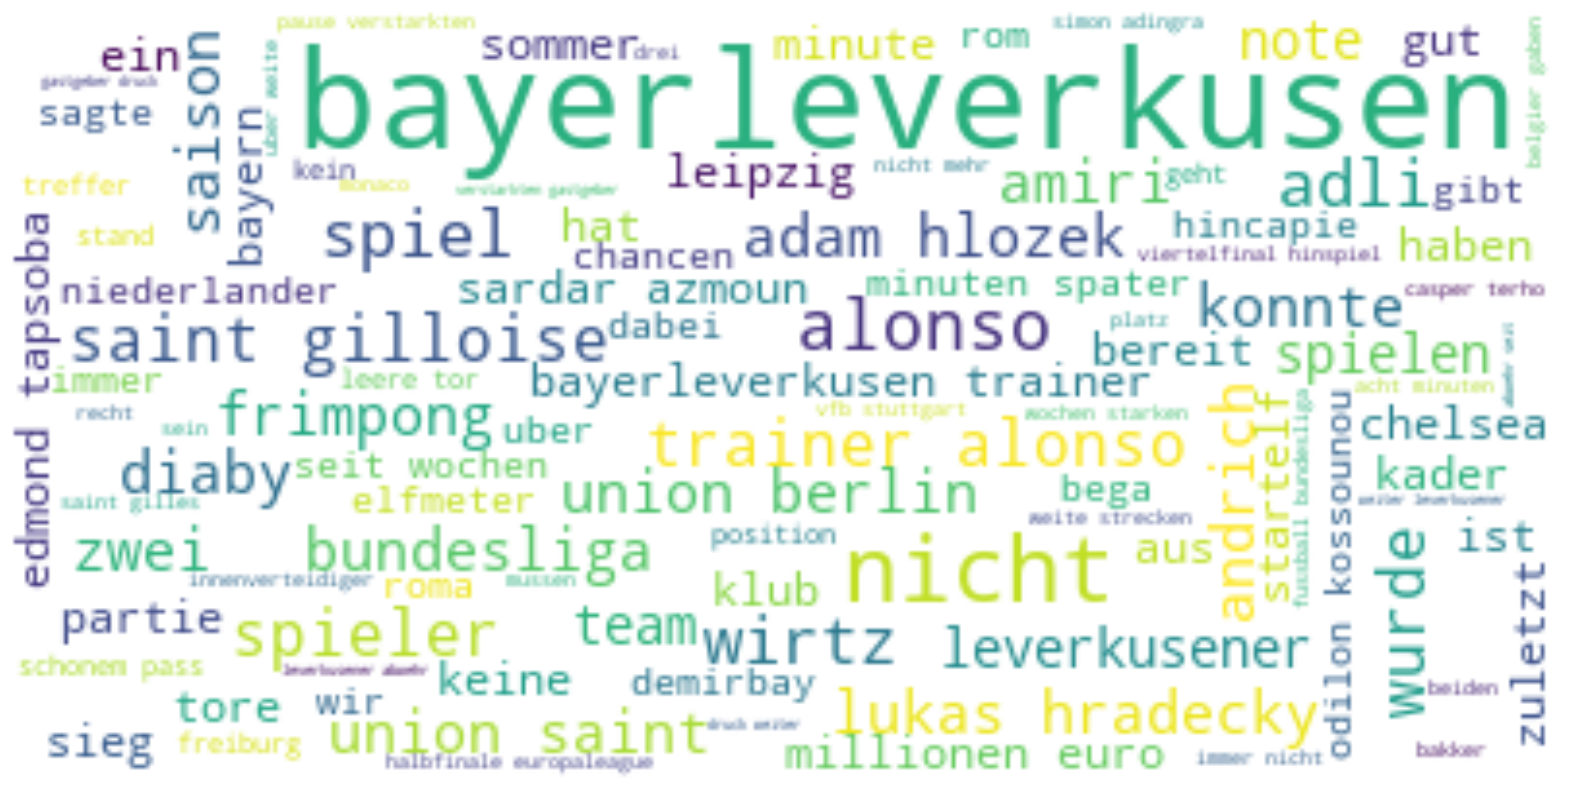

In [124]:
# Store the complete text in all_text
all_text = df['data'].str.cat(sep=' ')

# Create a plot
plt.figure(figsize=(20,20))

# Create a wordcloud and show in the plot
wordcloud = WordCloud( background_color="white").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [125]:
# Remove the words which add noice to clustering approach
# Define words to delete
stopwords = {"bayerleverkusen", "leverkusen", "nicht", "uber", "geht", "hat", "sein", "konnte", "ein", "gibt", "ist"}

# Apply the remove_stopwords function to the 'data' column using the apply method
df['data'] = df['data'].apply(lambda x: remove_stopwords(x, stopwords))

## Stemming
For the reason of interpretability we used the stemming approach. We choose interpretability over possible performance, because it was already hard to understand the context of the paragraph due to our preprocessing. To keep as much readability of the originial paragraphs as possible we took the stemming approach. We advice to take a deeper look into the approach of tokenization. Tokenization is the process of breaking down a text into individual units called tokens, such as words or subwords to prepare it. Each token acts as a discrete building block that allows a computer to understand and process the text more effectively. The approach of tokenization in addition to other models should be discovered in the future by Bayer04 Leverkusen in order to reach a better accuracy.

In [126]:
# Create copy of the data
df_stem = df.copy()

# Create stemmed data
df_stem['data'] = df_stem['data'].apply(stem_text)

# Print out stemmed data
df_stem

,data,player,language,publishedAt
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z
...,...,...,...,...
605,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z
606,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z
607,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z
608,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z


In [127]:
# Remove the similiar rows (The Function is imported from utils on top)
df_stem = remove_similar_rows_per_player(df_stem, df_stem['player'].unique())

## Vectorize data 
Because the clustering algorithms can only interpret numbers, we transformed our text data into numeric data. For that, we used the Term Frequency-Inverse Document Frequency. TF-IDF can be used to measure document similarities and is therefore fitting for our following modeling approach. 
The benefits of this approach are that it not only takes into account the appearances of a word within a document but also weights the importance of the given word. By considering the frequency of the word over all documents, words that appear rarely are weighted higher. Another benefit is that we can adjust our number of Features by cutting out common and rare words. For that, we choose to delete the words which appear in more than 95% of the documents and less than 2% of the documents. For clustering, especially words that appear in all documents and therefore in all clusters, add noise to the approach because they can't be fitted into clusters. We deleted the most common and rare words to reduce the noise and feature space of our data.

Another approach that should be tested in the future is to use Word2Vec or Doc2Vec embeddings. The word embeddings do also take the context of words into account. This context can't be caught with TF-IDF. 

In [128]:
# Define tfidf vectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.02)

# Apply vectorizer to the data 
df_tfidf = tfidf.fit_transform(df_stem.data).toarray()

In [129]:
# Print the tfidf vector
df_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [130]:
# Store the frequency matrix in data_tfidf 
data_tfidf = pd.DataFrame(df_tfidf, columns=tfidf.vocabulary_.keys())

# Print out the frequency matrix
data_tfidf.head()

,trainer,alonso,fan,monaco,tor,sechser,droht,paus,dafur,lang,...,reih,freistehend,end,bedient,zog,winter,doppelpass,verwertet,halbchancen,lautstark
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.299362,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
# Store the feature names in a words list
words = data_tfidf.columns.tolist()[:-2] 

# Print out the feature names
words

['trainer',
 'alonso',
 'fan',
 'monaco',
 'tor',
 'sechser',
 'droht',
 'paus',
 'dafur',
 'lang',
 'zudem',
 'seit',
 'woch',
 'amiri',
 'demirbai',
 'andrich',
 'erklart',
 'budapest',
 'spiel',
 'donnerstag',
 'hinspiel',
 'europaleagu',
 'sah',
 'defens',
 'mittelfeldspiel',
 'erfolg',
 'dritt',
 'gelb',
 'kart',
 'gesperrt',
 'werkself',
 'zuletzt',
 'bakker',
 'abschluss',
 'jedoch',
 'startelf',
 'steht',
 'mittelfeld',
 'sech',
 'muss',
 'stehen',
 'bereit',
 'allerd',
 'argentinischen',
 'weltmeist',
 'beid',
 'eigentlich',
 'verletzt',
 'zumindest',
 'union',
 'berlin',
 'chancen',
 'deutlich',
 'saint',
 'gillois',
 'alten',
 'erneut',
 'schwer',
 'kamen',
 'zuschauern',
 'minut',
 'gast',
 'fuhrung',
 'fussbal',
 'bundesligisten',
 'gut',
 'borussia',
 'dortmund',
 'entscheidenden',
 'moment',
 'gab',
 'bundesliga',
 'zuruck',
 'spielen',
 'weit',
 'auf',
 'platz',
 'sagt',
 'zweiten',
 'halft',
 'bisschen',
 'gefahrlich',
 'sind',
 'bracht',
 'diesmal',
 'grossen',
 'sehr

# KMeans clustering approach
The approach we took to derive topics from our articles is KMeans clustering. KMeans Clustering is a model which groups the documents into groups based on their similarities. To measure the similarities between documents KMeans uses cosine similarity. That is why KMeans is proficient at identifying groups of articles with similar content. Also, the approach is easily interpretable and can be used with smaller and bigger datasets. This is crucial because, for now, our dataset is small because of the API restrictions. But if Bayer Leverkusen decides to use the API commercially, the dataset size will increase significantly, and the KMeans approach can still be kept. 
The downsides of the approach are that the model is susceptible to the number of k's and the random initial assignment of clusters. Also, if the clusters are assigned correctly is very subjective and should therefore be checked by multiple people. 

Our first approach was to choose 4 clusters and examine how the assigned clusters fit the data to get a feeling of the KMeans model. To minimize the risk of sensitivity to the initial cluster assignment, we set the maximum number of iterations of 1000. This allows the model to readjust the clusters by keeping good performance. 

We advise to try out BERT models for the task at hand. BERT models can be used for clustering by first converting text data into numerical embeddings that capture the contextual meaning of words. These embeddings are then used to group similar text documents together, helping to discover underlying patterns and themes in the data. These models deliver high performance but come with less interpretability. 


In [132]:
# Create a KMeans model with a clusters size of 4
kmeans = KMeans(n_clusters = 4, max_iter=1000, random_state=42)

# Fit model with data
kmeans.fit(data_tfidf)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=1000, n_clusters=4, random_state=42)

In [133]:
# Store the common words for each cluster
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

In [134]:
# Print out the most common words for each cluster
for num, centroid in enumerate(common_words):
    words_in_centroid = [words[word] for word in centroid if word < len(words)]
    print(f"{num}: {', '.join(words_in_centroid)}")

0: amiri, platz, kommenden, marvin, sardar, reicht, dortmund, bellarabi, union, entscheidung
1: besser, linken, gillois, leistungen, starker, sech, marvin, stuttgart, verzog, hinten
2: spiel, pass, millionen, versuch, sieg, vergangenen, endspiel, jona, grossen, defens
3: rote, gesetzt, leistungen, rannten, spanier, korperlichkeit, starker, nehmen, marvin, edmond


In [135]:
# Create copy of original dataframe
df_kmeans = df_stem.copy()

In [136]:
# Add the clusters as lables to the data 
df_kmeans['cluster'] = kmeans.labels_
df_kmeans

,data,player,language,publishedAt,cluster
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,2
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,2
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,2
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,2
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,2
...,...,...,...,...,...
77,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z,3
78,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z,3
79,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z,3
80,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z,3


In [137]:
# Show the number of documents within each cluster
clusters = df_kmeans.groupby(['cluster']).size()
clusters

cluster
0    184
1     59
2    224
3    130
dtype: int64

We can see that the clusters are not equally distributed over the articles. After looking deeper into the assigned clusters we were not able to make sense of the clusters and we could not assign specific topic names to the clusters. We conclude that 4 is not the optimal number of clusters, because the assigned four clusters are too general and can't be used to form topics.

## Try out different cluster sizes
To find out an appropriate number of clusters, we created 13 different models with cluster sizes 2-15. We then examined each cluster assignment of the model individually to see if it was possible to derive topics out of the predicted clusters. 

In [138]:
# Create list where the models will be stored
kmeans_models_arr = {'cluster_' + str(iter): '' for iter in range(2, 15)}

# Create models with 2-15 clusters
for iter in range(2, 15): 
    
    # Create a KMeans model
    model = KMeans(n_clusters = iter, max_iter=1000, random_state=42)

    # Fit with data
    model.fit(data_tfidf)

    # Add the model to the list
    kmeans_models_arr.update({'cluster_'+ str(iter): model})


/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_k

The following examination of cluster assignment was done iteratively for all given cluster sizes. We shortened the code to just the examination of the cluster size 8 because this was the number of clusters we went with in the end. 

Our experience was that choosing a small cluster size leads to very general clusters, which are not really precise. Selecting a higher cluster size results in more specific clusters. We found that topics within the clusters doubled with the approach of choosing a larger cluster size. Therefore we chose a more extensive cluster size of 8 and then aggregated the clusters to three central topics. 

In [139]:
# Store the common words for a cluster
common_words = kmeans_models_arr['cluster_8'].cluster_centers_.argsort()[:,-1:-31:-1]

# Print out most common words
for num, centroid in enumerate(common_words):
    words_in_centroid = [words[word] for word in centroid if word < len(words)]
    print(f"{num}: {', '.join(words_in_centroid[:30])}")

0: rannten, korperlichkeit, spanier, samstag, moment, schlug, spiel, vollendet, konter, defens, endspiel, naturlich, gemacht, fan, nehmen, ubernahm, millionen, leistung, pass, kampf, aktuel, stieler, reicht, per, rote, edmond, ruckstand, frankfurt, spielen, arbeit
1: dortmund, abseit, platz, letzten, millionen, verteidig, deutlich, mitt, winter, lasst, viel, worden, erstmal, tor, sowi, da, wurden, dritten, traumen, gast, rettet, budapest, insgesamt, sturmer, fuhrung, wahrend, mannschaft, star, freistoss, gladbach
2: besser, leistungen, gillois, linken, sech, marvin, paar, meist, internationalen, problem, schlusspfiff, euro, stuttgart, abraham, muss, bisschen, duell, verzog, hinten, wirtz, schliesslich, adli, zuruck, mai, verteidigt, woch, hradecki, trotzdem, naturlich, belgischen
3: spiel, millionen, pass, defens, versuch, angriff, hinspiel, drei, sonntag, patricio, endspiel, freistoss, jung, spater, schlusspfiff, verrichten, gar, jona, mussen, leagu, strafstoss, jahren, tapsoba, platz

## Cluster naming
To name the clusers accordingly we first took a look on the most common words per clusters to get a feeling of what the clusters are about. The next step then was to select the articles per cluster and read through them. By applying domain knowledge we then assigned fitting topics to each cluster in order to make the clusters human interpretable. 

We explored that some clusters can be aggregated into the same topic. The three central topics we found are "Europa League", "Game Situations and Match Performance" and "Bundesliga News". Creating topic names was done by common sense and the help of expert knowledge by Bayer Leverkusens Data Scientists. 
The corresponding topics to the cluster names we found are the following:
___
0 = Europa League
___
1 = Bundesliga news
___
2 = Europa League
___
3 = Game Situations and Match Performance
___
4 = Europa League
___
5 = Game Situations and Match Performance
___
6 = Bundesliga News
___
7 = Europa League

In [140]:
# Assign cluster to dataframe
df_kmeans['cluster'] = kmeans_models_arr['cluster_8'].labels_
df_kmeans

,data,player,language,publishedAt,cluster
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,3
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,3
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,3
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,3
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,3
...,...,...,...,...,...
77,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z,0
78,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z,0
79,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z,0
80,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z,0


In [141]:
# Map the clusters to topics
def map_cluster_topic(cluster):
    if cluster == 3 or cluster == 5:
        return 'Game Situations and Match Performance'
    elif cluster == 1 or cluster == 6 :
        return 'Bundesliga News'
    elif cluster == 0 or cluster == 2 or cluster == 4 or cluster ==7:
        return 'Europa League'


# Apply the function and create the topic column
df_kmeans['topic'] = np.vectorize(map_cluster_topic)(df_kmeans['cluster'])

In [142]:
# Store the data in a csv file
#df_kmeans.to_csv('../data_files/data_clustering/clustered_data_kmeans_ger_v2.csv', index=False)


In [143]:
# Store the model in a pickle file 
#with open('de_clustering_model_final.pkl', 'wb') as file:
#    pickle.dump(kmeans_models_arr['cluster_8'], file)

## Examining cluster dirstribution and prediction probabilities for clusters
Because we examined that many documents could be assigned to more than just one cluster, we wanted to look at the distance of the documents to each cluster. With this, we looked deeper into how similar the articles and clusters are. We saw that the clusters are very close and that the probabilities of a document lying within a cluster are usually similar for all the clusters. We explain that with the fact that all the articles talk about the same overall topic, football. Therefore the wording of articles is similar in the first place, and nuances decide on in which topic a document lies. 

In [144]:
# Examine the number of data points within a cluster
clusters = df_kmeans.groupby(['cluster']).size()
clusters

cluster
0     57
1     19
2     41
3    137
4     42
5    124
6    146
7     31
dtype: int64

In [145]:
# Compute the distances to the cluster centroids
distances = kmeans_models_arr['cluster_8'].transform(data_tfidf)

# Calculate cluster membership probabilities
membership_probs = np.exp(-distances) / np.sum(np.exp(-distances), axis=1, keepdims=True)

# Print the membership probabilities for each data point
print(membership_probs)

[[0.12899175 0.11536621 0.11530469 ... 0.1311489  0.13192106 0.11896967]
 [0.12881786 0.11047435 0.11569497 ... 0.13065358 0.13204598 0.11968654]
 [0.13062921 0.11234198 0.11201346 ... 0.12817373 0.1328675  0.11958628]
 ...
 [0.14509984 0.10830741 0.11507747 ... 0.13094518 0.12986454 0.1156231 ]
 [0.14392212 0.10840649 0.11447694 ... 0.13043067 0.12984573 0.11621928]
 [0.14726143 0.10739047 0.11678053 ... 0.12817449 0.12859121 0.11482917]]


In [146]:
# examinge the probability of a row lying in a cluster we can see that the propabilities are all close to each other
membership_probs[1]

array([0.12881786, 0.11047435, 0.11569497, 0.13679406, 0.12583266,
       0.13065358, 0.13204598, 0.11968654])

# Accuracy testing
To test the accuracy, we used the approach to manually prelable our data. To do so, we read through our initial data condensed and picked random articles where we assigned a topic based on domain knowledge. We then compared these manually pre labeled articles with the model labeling to calculate accuracy scores. 

We prelabeled 10 data points for each topic (accidentally 11 for Bundesliga News). We advise to pre label more data points to get more accurate scores, which we could not do because of time restrictions. 

In [147]:
# Load the prelabled and unlabled data 
df_prelabeled = pd.read_csv('../data_files/data_clustering/labeled-clustered_data_kmeans_ger_v2.csv', sep=';')
df_clustered = pd.read_csv('../data_files/data_clustering/clustered_data_kmeans_ger_v2.csv')

In [148]:
# Add the predicted lables to the prelabled df
df_prelabeled["predicted_topic"] = df_clustered["topic"]

# Remove empty rows 
df_prelabeled.dropna(inplace=True)

# Show the dataframe
df_prelabeled.head(10)

,data,player,language,publishedAt,Label,predicted_topic
6,gut fehlentscheidung sascha stegemann borussia dortmund meisterschaft kostet entscheidenden moment gab bundesliga histori mehrfach sportschau blickt zuruck,exequiel palacios,de,2023-03-09T20:18:19Z,Bundesliga News,Bundesliga News
14,sonntagspartien fussbal bundesliga spieltag uberblick joshua kimmich nationalmannschaft abwesenheit manuel neuer kommenden woch kapitan anfuhren wird munchner fuhrung gebracht argentini einzig aktuel weltmeist bundesliga dreht spiel zwei foulelfmetern kurio schiedsricht tobia stieler beiden aktionen benjamin pavard dayot upamecano gefoulten adli wegen vermeintlich schwalben zunachst gelb gegeben beid male nahm kart videostudium zuruck beid male entschuldigt adli beid male zeigt verspatung punkt drucker bevor munchner erst chanc hatten gab weiter chancen diabi frimpong uberraschend jeweil ecken torschuss minuten prozent ballbesitz gastgeb dann nicht schlug serienmeist eiskalt leon goretzka legt kimmich schuss odilon kossoun unhaltbar latt abfalscht bereit kimmich vierter saisontreff mehr lediglich saison sech,exequiel palacios,de,2023-03-19T18:35:00Z,Bundesliga News,Bundesliga News
24,borussia dortmund sagt schiri boss gluck entscheidung all schelt video assistenten immer langst immer recht einstecken mussen bot sonntaglich spiel bayern munchen deutlichen kuriosen kontrast zweimal nahm schiedsricht tobia stieler schwalb adli strafraum bayern wahr verwarnt deshalb jeweil beid male interveniert var soren stork jedoch vollig recht adli klar gefoult worden war stieler nahm folgerichtig beiden fallen gelb kart zuruck bat adli per handschlag entschuldigung sprach leverkusenern strafstoss sicher verwandelt,exequiel palacios,de,2023-03-20T05:39:04Z,Bundesliga News,Bundesliga News
42,alonso weiss final kommt gewinnt fruher welt europameist trainer schaffen einzug halbfinal klappen donnerstag hofft nationalspiel einsatz argentinischen weltmeist hinspiel oberschenkelproblemen ausgewechselt wurd mittwoch erstmal trainiert wir mussen sehen darauf reagiert deshalb fallt entscheidung donnerstag sagt rolf aber ware wichtig spielen letzten wochen dominant roll eingenommen,exequiel palacios,de,2023-04-19T13:04:13Z,Europa League,Game Situations and Match Performance
81,leipzig liegt zwei runden schluss deutschen bundesliga rang drei leipzig fixierten sonntag abschluss rund spat erfolg werder bremen punkt vorsprung vierten union berlin xaver schlager kam minut zweiten einsatz syndesmosebandriss eingewechselt wurd anstel landsmann konrad laimer stade renn ausgeliehen serhou guirassi bracht stuttgart minut per foulelfmet fuhrung argentinisch weltmeist strafstoss verschuldet hatt sorgt ebenfal per foulelfmet minut ausgleich schulter angeschlagen ofb teamtormann patrick pentz stand siebenten kader,exequiel palacios,de,2023-05-14T18:07:21Z,Bundesliga News,Bundesliga News
111,torschutzen sich wirtz jubeln tage wirtz darauf warten schutz schwarmt ich gar sagen seht immer individuel klass grossartig team viel einfach glucklich flo haben,jeremie frimpong,de,2023-04-02T12:05:20Z,Game Situations and Match Performance,Game Situations and Match Performance
155,gegner halbfinal europaleagu sich roma zeigt rotterdam mannschaft lage xaist einzig deutscher klub uberhaupt europapok dabei halbfinal der xaeuropa leagu bundesliga klub besiegt donnerstagabend belgischen vertret union saint gillois hinspiel ausgegangen trafen diabi minut michel bakker adam hlozek einzig tor belgier sorgt casper terho dpa,jeremie frimpong,de,2023-04-21T09:05:10Z,Europa League,Europa League
160,torschutz amiri recht jubeln treffer,jeremie frimpong,de,2023-04-23T17:33:57Z,Game Situations and Match Performance,Game Situations and Match Performance
211,gereizt bayern spannendsten titelkampf seit jahren meisterlich zuruckgeschlagen munchner dauer champion konterten angriff borussia dortmund bundesliga thron topspiel union berlin machtigen offens spielfreud kront fussbal starensembl trainer julian nagelsmann

In [149]:
# Store the true and predicted lables 
actual_labels = df_prelabeled['Label']
predicted_labels = df_prelabeled['predicted_topic']

# Generate classification report
report = classification_report(actual_labels, predicted_labels)

# Print the report
print(report)


                                       precision    recall  f1-score   support

                      Bundesliga News       0.89      0.73      0.80        11
                        Europa League       1.00      0.90      0.95        10
Game Situations and Match Performance       0.69      0.90      0.78        10

                             accuracy                           0.84        31
                            macro avg       0.86      0.84      0.84        31
                         weighted avg       0.86      0.84      0.84        31



We can see the Precision and Recall of our prediction model from the classification report. The model performs better than random (33% threshold) over all classes. The model has an overall f1-accuracy score of 84%, which is high for an unsupervised approach. 

The best accuracy is achieved over the prediction of the topic "Europa League" The model avoids false positives all the time and identifies the positive cases 90% of the time. The lowest Recall delivers the prediction for "Game Situations and Match Performance." Here the model can avoid the false-positives in 69% of the cases while the Recall is at 90%. For Bundesliga News, the Precision is 89% and the Recall 73%. 

In [150]:
# Create confusion matrix
confusion_mat = confusion_matrix(actual_labels, predicted_labels)

# Print the confusion matrix
print(confusion_mat)


[[8 0 3]
 [0 9 1]
 [1 0 9]]


[Text(0, 0.5, 'Bundesliga'),
 Text(0, 1.5, 'Euro-League'),
 Text(0, 2.5, 'Match Performance')]

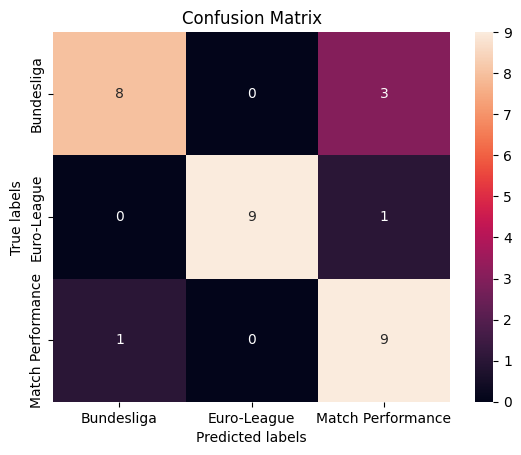

In [151]:
# Create a heatmap plot to examine the errors   
ax= plt.subplot()
sns.heatmap(confusion_mat, annot=True, fmt='g', ax=ax)

# Set labels, title and ticks and plot the heatmap
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Bundesliga', 'Euro-League', 'Match Performance'])
ax.yaxis.set_ticklabels(['Bundesliga', 'Euro-League', 'Match Performance'])

The True Label Bundesliga News has the highest error rate, predicted as Game Situations and Match Performance three times. The error is explainable by the similarity of both topics. Let's look at specific Bundesliga news rows, which are predicted as Game Situations and Match Performance. We can see that within the article paragraphs, there is also text about how the players acted within games. Therefore parts of the article are in both clusters. 

In [152]:
# Set display options to show all rows
pd.set_option('display.max_colwidth', None)

df_prelabeled[ (df_prelabeled["predicted_topic"] == 'Game Situations and Match Performance') & (df_prelabeled["Label"] == "Bundesliga News") ]


,data,player,language,publishedAt,Label,predicted_topic
211,gereizt bayern spannendsten titelkampf seit jahren meisterlich zuruckgeschlagen munchner dauer champion konterten angriff borussia dortmund bundesliga thron topspiel union berlin machtigen offens spielfreud kront fussbal starensembl trainer julian nagelsmann sonntag zuschauern allianz arena tore eric maxim choupo mote minut kingslei coman geburtstagskind jamal musiala xain nachspielzeit halft gesperrten hincapi adli auskommen musst ruckstand knabbern kurz paus kratzten gast ausgleich auffallig diabi schlug ball verzettelt demirbai pruft torhut mark flekken abwesenheit gunter kapitansbind trug gewaltschuss zweiten reih zudem kopft frimpong freistehend kasten,jonathan tah,de,2023-02-26T18:32:00Z,Bundesliga News,Game Situations and Match Performance
391,bayern freiburg pokal au woch zumindest wenig revanchiert vier tage viertelfin gewann deutsch fussbal rekordmeist bundesliga auswartsspiel freiburg verteidigt tabellenfuhrung bestimmten gastgeb parti gewannen verdient tore adli sardar azmoun eintracht reicht zwischenzeitlichen djibril sow,moussa diaby,de,2023-04-08T15:44:21Z,Bundesliga News,Game Situations and Match Performance
550,gladbach personalsorgen heimspiel augsburg julian weigl mittwoch mannschaftstrain auftauchen wurd abzusehen bosen foul schwere prellung linken unterschenkel zog mittelfeldspiel ich gratsch angst stark getroffen gluck ungluck teilnahm saisonfinal bangen,piero hincapie,de,2023-05-24T16:55:51Z,Bundesliga News,Game Situations and Match Performance


## Wordclouds per cluster
To examine a bit further if the Topic assignment makes sense we created Wordclouds for each given topic. With these wordclouds we are able to see if the most common words within a assigned topic really relate to the given topic. 

In [153]:
# Delete some unwanted words
df_clustered['data'] = df_clustered['data'].str.replace('Leverkusen', '')
df_clustered['data'] = df_clustered['data'].str.replace('seit', '')
df_clustered['data'] = df_clustered['data'].str.replace('leverkusen', '')
df_clustered['data'] = df_clustered['data'].str.replace('zwei', '')
df_clustered['data'] = df_clustered['data'].str.replace('drei', '')
df_clustered['data'] = df_clustered['data'].str.replace('vier', '')

In the following Wordcloud for "Bundesliga News," we can see that it represents the topic well because many words are related to Bundesliga. Many other Bundesliga clubs and players are mentioned in the wordcloud. Additionally to that Game related words are part of the wordcloud, which supports our thesis that the journalists tend to write about both topics, "Bundesliga News" and "Game Situations and Match Performance," within the same articles. 

/opt/homebrew/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


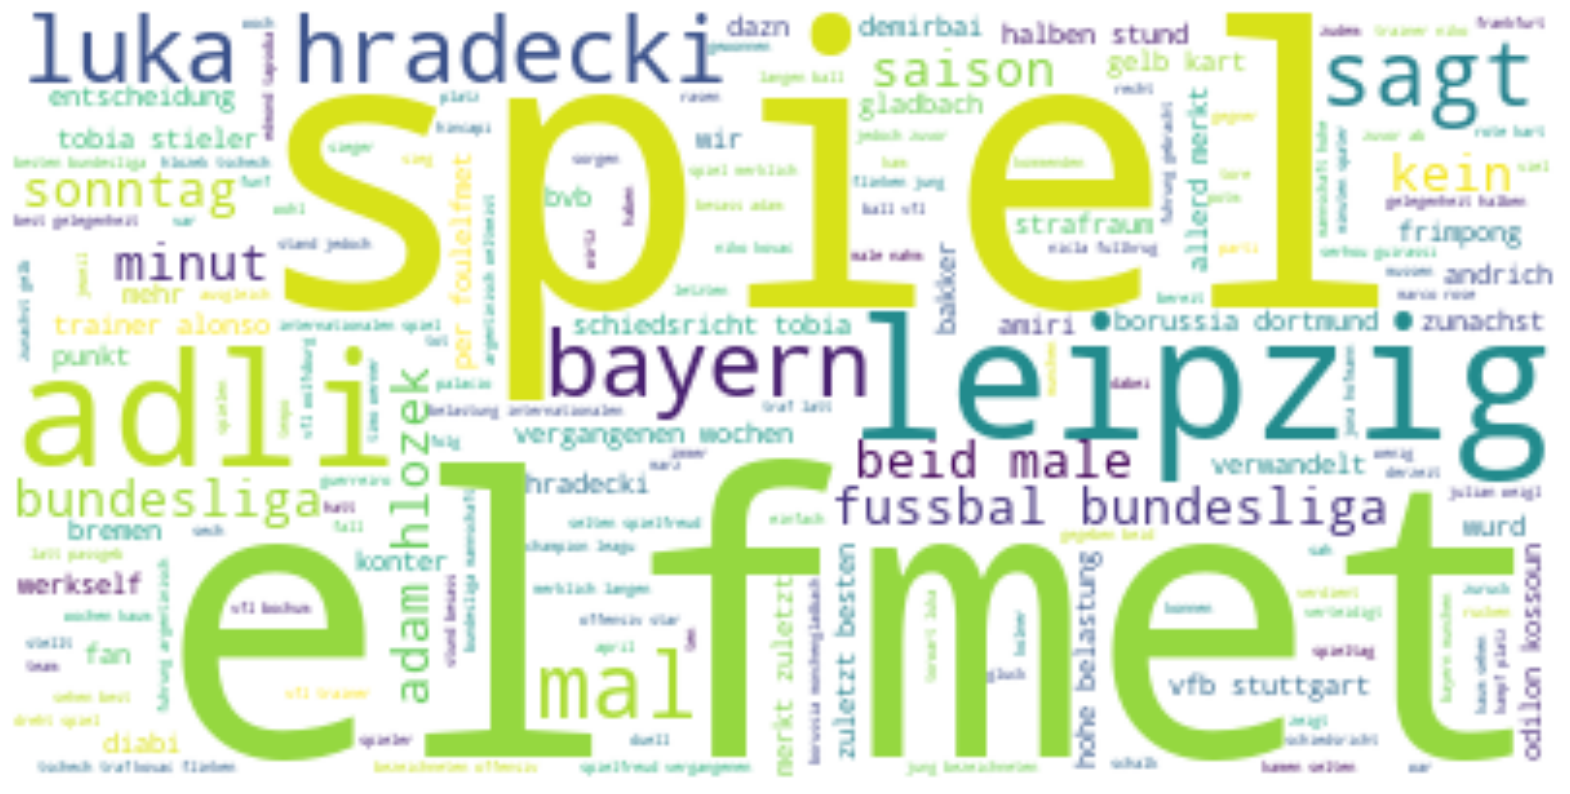

In [154]:
# Store the complete text in all_text
all_text_game_sit = df_clustered[ (df_clustered["topic"] == 'Bundesliga News')]['data'].str.cat(sep=' ')

# Create a plot
plt.figure(figsize=(20,20))

# Create a wordcloud
wordcloud = WordCloud( background_color="white").generate(all_text_game_sit)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In the following Wordcloud for "Europa League," we can see that it represents the topic well because many words are related to Europa League. Many interantional Clubs and citys are mentioned within the wordclouds. 

/opt/homebrew/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


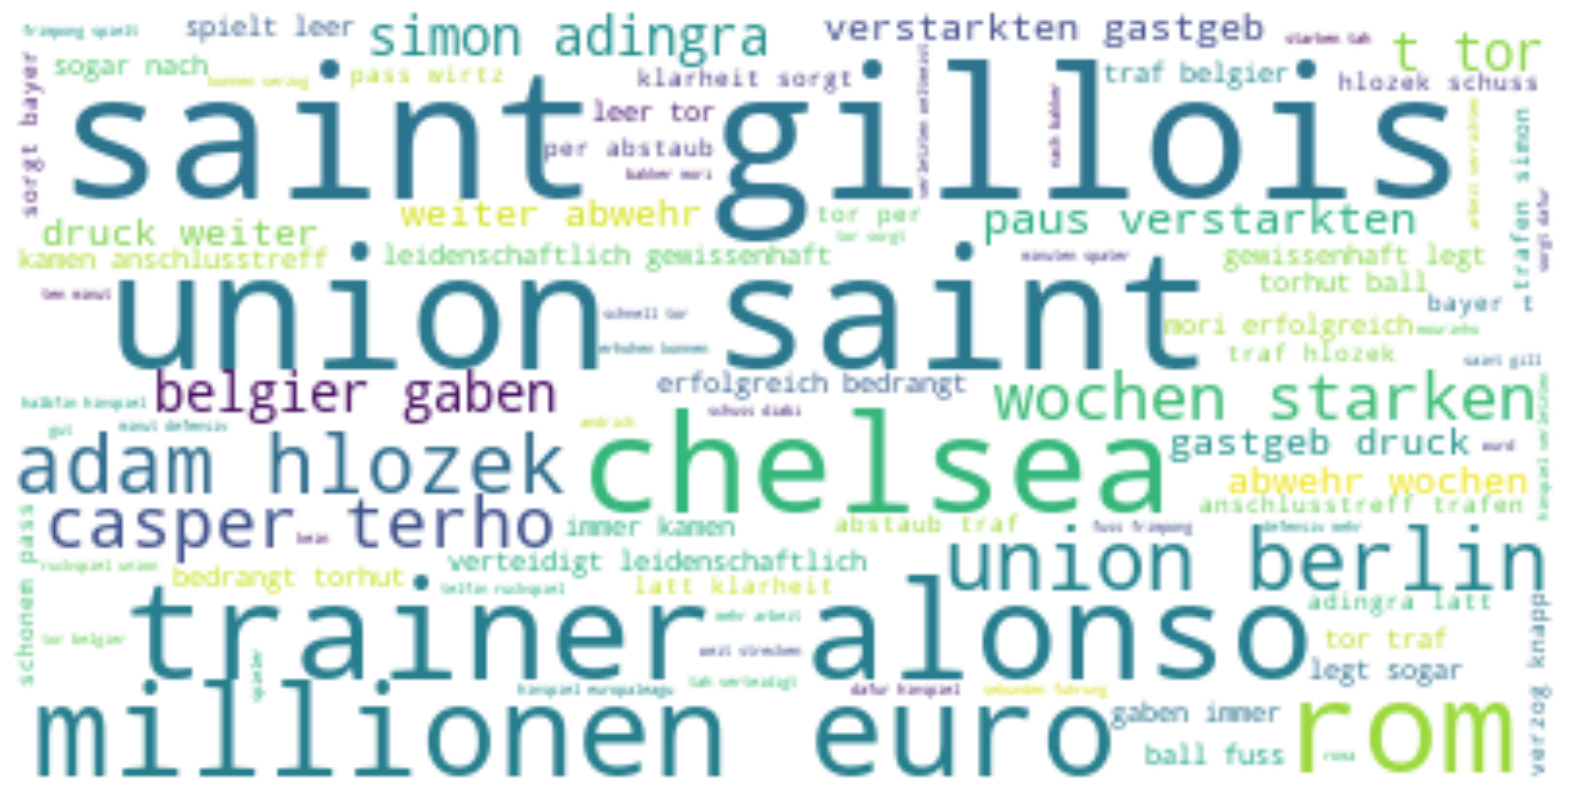

In [155]:
# Select whole text for Europa League articles 
all_text_game_sit = df_clustered[ (df_clustered["topic"] == 'Europa League')]['data'].str.cat(sep=' ')

# Create a plot
plt.figure(figsize=(20,20))

# Create a wordcloud
wordcloud = WordCloud( background_color="white").generate(all_text_game_sit)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In the following Wordcloud for "Game Situations and Match Performance," we can see that it represents the topic well because many words are related to the players and how they perform and play. Many game-related words and player names are mentioned within the wordcloud. Additionally, the coach of the team is often mentioned because he often comments on the players' performance. 

/opt/homebrew/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


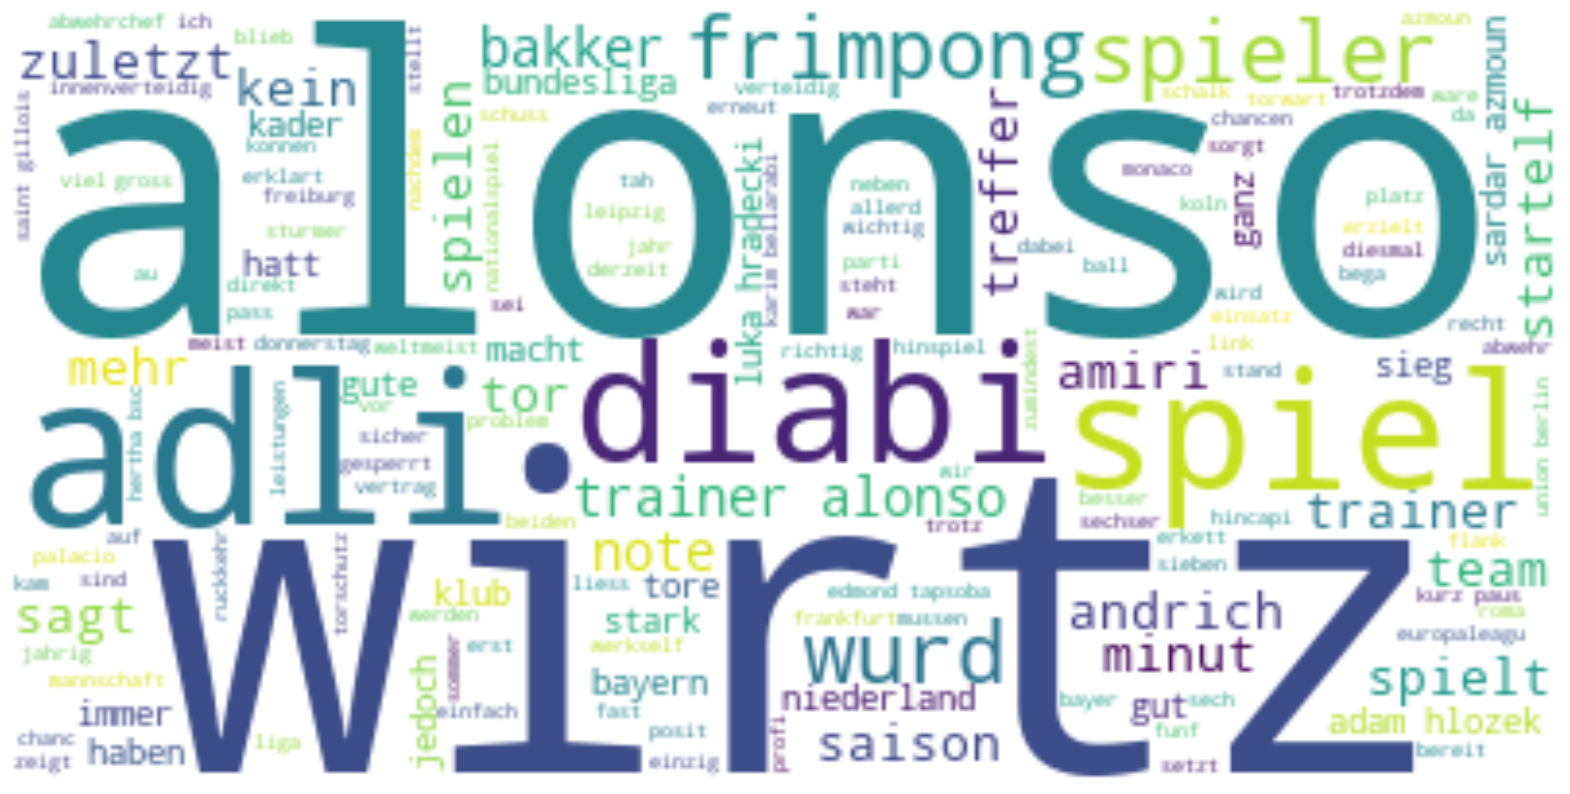

In [156]:
# Store the complete text in all_text
all_text_game_sit = df_clustered[ (df_clustered["topic"] == 'Game Situations and Match Performance')]['data'].str.cat(sep=' ')


# Create a plot
plt.figure(figsize=(20,20))

# Create a wordcloud
wordcloud = WordCloud( background_color="white").generate(all_text_game_sit)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Connect the topic data with the sentiment data
We combined both topic and sentiment data into one dataset to build our dashboards with the information.

In [157]:
# Read in sentiment file 
df_sentiment = pd.read_csv('../data_files/data_sentiment/data_sentiment_final.csv')

# Select german data and only needed columns
df_sentiment = df_sentiment[df_sentiment["language"] == "de"]
df_sentiment = df_sentiment.loc[:, ['publishedAt', 'player', 'sentiment']]

# Keep only last name
df_clustered['player'] = df_clustered['player'].str.lstrip().str.split(n=1).str[-1]


In [158]:
# Merge the two dataframes on the pubishedAt and player name
merged_df = pd.merge(df_clustered, df_sentiment, on=['publishedAt', 'player'], how='left')

In [159]:
# Look at if Dataframe size is the same 
print('size of the previous clustered Dataframe : ', str(len(df_clustered)), '\n',
      'size of the merged Dataframe : ', str(len(merged_df)))

size of the previous clustered Dataframe :  597 
 size of the merged Dataframe :  597


In [160]:
# Loading the merged df into a csv in order to load into hex 
#merged_df.to_csv('../data_files/data_clustering/clustered_data_kmeans_plus_sentiment_ger.csv', index=False)

# Summary
Please remark that the clustering Part until this Point represents our chosen model. The following exploration of LDA topic modeling is just the code of another approach we tried but did not choose. The reason for not selecting the LDA Model was that it was not able for us to derive concrete topics with the LDA Model. We explain that because the articles are too similar to derive clear topics with this approach.

To summarize, we used the stemming and TF-IDF approach out of interpretability reasons. Based on that we created a KMeans model with a cluster size 8 to gather specific clusters for the articles. In the next step, we aggregated these 8 clusters into three central topics, representing the corresponding articles well. We achieved an overall performance of 84% with this approach.

# Next steps for Bayer04 Leverkusen
We advise you to refrain from continuing on the further development of the following LDA modeling because we found that this approach is not appropriate for the data at hand. But we encourage the use of Embeddings and models that consider context, like BERT models. Furthermore we advise to manually prelabel more data in order to get more accurate accuracy scores on the developed model.

## LDA Model
We created a corpus and dictionary from the stemmed data we also used for clustering and made one LDA model with a number of topics 4 as a baseline.

In [161]:
# Split the texts into a list of words
texts = [text.split() for text in df_stem['data']]

# Create the Gensim dictionary
dictionary = corpora.Dictionary(texts)

# Remove rare and common words from the dictionary
dictionary.filter_extremes(no_below=118, no_above=0.95)

# Derive the absolute frequency matrix using doc2bow
corpus = [dictionary.doc2bow(text) for text in texts]


In [162]:
# Create one lda model with 4 clusters
lda = models.LdaModel(corpus, num_topics=4, id2word=dictionary, chunksize=10, iterations=100, passes=10, random_state=42)

In [163]:
# Show topics of the lda model
lda.show_topics()

[(0,
  '0.235*"wirtz" + 0.231*"frimpong" + 0.185*"diabi" + 0.177*"ball" + 0.171*"leverkusen" + 0.000*"alonso" + 0.000*"trainer" + 0.000*"spiel"'),
 (1,
  '0.993*"alonso" + 0.001*"wirtz" + 0.001*"leverkusen" + 0.001*"trainer" + 0.001*"frimpong" + 0.001*"spiel" + 0.001*"diabi" + 0.001*"ball"'),
 (2,
  '0.987*"spiel" + 0.002*"wirtz" + 0.002*"leverkusen" + 0.002*"ball" + 0.002*"alonso" + 0.002*"trainer" + 0.002*"diabi" + 0.002*"frimpong"'),
 (3,
  '0.990*"trainer" + 0.001*"frimpong" + 0.001*"ball" + 0.001*"alonso" + 0.001*"leverkusen" + 0.001*"diabi" + 0.001*"wirtz" + 0.001*"spiel"')]

In [164]:
# Create copy of df 
df_lda = df_stem.copy()

# Append the predicted clusters to df_stem
topics=lda[corpus]
df_lda['lda_predicted_topics']= [max(topics[i],key=lambda item:item[1])[0] for i in range(len(topics))]

In [165]:
# Look at predicted topics
df_lda.head()

,data,player,language,publishedAt,lda_predicted_topics
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,3
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,0
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,2
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,1
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,0


In [166]:
# Examine clusters

# Enable interactive visualization in the notebook using pyLDAvis
pyLDAvis.enable_notebook()

# Prepare the data for visualization with pyLDAvis
LDAvis_prepared = prepare(lda, corpus, dictionary)

# Display visualization
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.125798  0.117269       1        1  52.108477
1      0.416084 -0.016576       2        1  18.700630
3     -0.156018 -0.373761       3        1  15.433438
2     -0.134268  0.273068       4        1  13.757455, topic_info=         Term        Freq       Total Category  logprob  loglift
0      alonso  285.000000  285.000000  Default   8.0000   8.0000
1     trainer  234.000000  234.000000  Default   7.0000   7.0000
2       spiel  208.000000  208.000000  Default   6.0000   6.0000
6       wirtz  188.000000  188.000000  Default   5.0000   5.0000
5    frimpong  185.000000  185.000000  Default   4.0000   4.0000
4       diabi  148.000000  148.000000  Default   3.0000   3.0000
3        ball  142.000000  142.000000  Default   2.0000   2.0000
7  leverkusen  137.000000  137.000000  Default   1.0000   1.0000
5    frimpong  184.101928  185.101404   Topic1  -1.4663   0.6464
6       wirtz  187.473872  188.569377   Topic1  -1.4482   0.6460
4       diabi  147.371091  148.367608   Topic1  -1.6889   0.6451
3        ball  141.585531  142.604011   Topic1  -1.7289   0.6447
7  leverkusen  136.573978  137.600427   Topic1  -1.7650   0.6444
2       spiel    0.222246  208.736321   Topic1  -8.1858  -6.1932
1     trainer    0.225655  234.868356   Topic1  -8.1706  -6.2959
0      alonso    0.226478  285.152493   Topic1  -8.1669  -6.4863
0      alonso  284.208436  285.152493   Topic2  -0.0074   1.6733
7  leverkusen    0.298004  137.600427   Topic2  -6.8677  -4.4584
3        ball    0.290899  142.604011   Topic2  -6.8918  -4.5182
4       diabi    0.292933  148.367608   Topic2  -6.8849  -4.5509
6       wirtz    0.330101  188.569377   Topic2  -6.7654  -4.6712
5    frimpong    0.295004  185.101404   Topic2  -6.8778  -4.7651
2       spiel    0.294345  208.736321   Topic2  -6.8801  -4.8875
1     trainer    0.296910  234.868356   Topic2  -6.8714  -4.9967
1     trainer  233.969960  234.868356   Topic3  -0.0098   1.8648
7  leverkusen    0.331663  137.600427   Topic3  -6.5687  -4.1594
3        ball    0.334165  142.604011   Topic3  -6.5612  -4.1876
4       diabi    0.330197  148.367608   Topic3  -6.5731  -4.2391
5    frimpong    0.334716  185.101404   Topic3  -6.5595  -4.4467
6       wirtz    0.328697  188.569377   Topic3  -6.5777  -4.4835
2       spiel    0.322487  208.736321   Topic3  -6.5967  -4.6041
0      alonso    0.334042  285.152493   Topic3  -6.5615  -4.8809
2       spiel  207.897243  208.736321   Topic4  -0.0130   1.9796
7  leverkusen    0.396781  137.600427   Topic4  -6.2745  -3.8651
3        ball    0.393416  142.604011   Topic4  -6.2830  -3.9094
4       diabi    0.373387  148.367608   Topic4  -6.3352  -4.0012
6       wirtz    0.436707  188.569377   Topic4  -6.1786  -4.0844
5    frimpong    0.369756  185.101404   Topic4  -6.3450  -4.2322
1     trainer    0.375830  234.868356   Topic4  -6.3287  -4.4541
0      alonso    0.383537  285.152493   Topic4  -6.3084  -4.6278, token_table=      Topic      Freq        Term
term                             
0         2  0.995958      alonso
3         1  0.995764        ball
4         1  0.990782       diabi
5         1  0.994050    frimpong
7         1  0.995636  leverkusen
2         4  0.996472       spiel
1         3  0.996303     trainer
6         1  0.991677       wirtz, R=8, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

## Finding the best number of topics
To find a fitting number of topics, we created models with topic sizes 2-15 and examined them individually. 
The model with the most accurate-looking topics was with eight topics. Therefore this one is used in the following code.

In [167]:
# Create multiple LDA models with different topic sizes 2-15
models_arr = {'topic' + str(iter): '' for iter in range(2, 15)}
for iter in range(2, 15): 
    models_arr.update({'topic_'+ str(iter): models.LdaModel(corpus, num_topics=iter, id2word=dictionary, chunksize=150, iterations=100, passes=20, random_state=42)})

In [168]:
# Show topics for a certain cluster
models_arr['topic_8'].show_topics(num_words = 15)

[(0,
  '0.676*"frimpong" + 0.172*"ball" + 0.149*"diabi" + 0.000*"leverkusen" + 0.000*"trainer" + 0.000*"alonso" + 0.000*"wirtz" + 0.000*"spiel"'),
 (1,
  '0.398*"ball" + 0.281*"diabi" + 0.126*"trainer" + 0.110*"alonso" + 0.082*"leverkusen" + 0.001*"frimpong" + 0.001*"wirtz" + 0.001*"spiel"'),
 (2,
  '0.993*"leverkusen" + 0.001*"alonso" + 0.001*"spiel" + 0.001*"ball" + 0.001*"diabi" + 0.001*"wirtz" + 0.001*"frimpong" + 0.001*"trainer"'),
 (3,
  '0.715*"alonso" + 0.227*"wirtz" + 0.053*"trainer" + 0.001*"spiel" + 0.001*"leverkusen" + 0.001*"ball" + 0.001*"diabi" + 0.001*"frimpong"'),
 (4,
  '0.863*"spiel" + 0.133*"ball" + 0.001*"trainer" + 0.001*"alonso" + 0.001*"wirtz" + 0.001*"diabi" + 0.001*"leverkusen" + 0.001*"frimpong"'),
 (5,
  '0.547*"trainer" + 0.451*"alonso" + 0.000*"ball" + 0.000*"spiel" + 0.000*"frimpong" + 0.000*"wirtz" + 0.000*"diabi" + 0.000*"leverkusen"'),
 (6,
  '0.642*"diabi" + 0.353*"wirtz" + 0.001*"trainer" + 0.001*"leverkusen" + 0.001*"alonso" + 0.001*"frimpong" + 0.0

In [169]:
# Enable interactive visualization in the notebook using pyLDAvis
pyLDAvis.enable_notebook()

# Prepare the data for visualization with pyLDAvis
LDAvis_prepared = prepare(models_arr['topic_8'], corpus, dictionary)

# Display visualization
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.391510  0.125143       1        1  18.390923
0      0.253968 -0.016242       2        1  14.598279
1     -0.004586  0.043081       3        1  13.147117
4      0.198953  0.212930       4        1  12.470749
6      0.103904 -0.302833       5        1  11.832985
7      0.079280 -0.234132       6        1  11.480896
2      0.079820  0.290278       7        1   9.086151
3     -0.319829 -0.118226       8        1   8.992900, topic_info=          Term        Freq       Total Category  logprob  loglift
2        spiel  165.000000  165.000000  Default   8.0000   8.0000
7   leverkusen  159.000000  159.000000  Default   7.0000   7.0000
0       alonso  248.000000  248.000000  Default   6.0000   6.0000
6        wirtz  241.000000  241.000000  Default   5.0000   5.0000
5     frimpong  151.000000  151.000000  Default   4.0000   4.0000
..         ...         ...         ...      ...      ...      ...
5     frimpong    0.127120  151.904497   Topic8  -6.9876  -4.6771
7   leverkusen    0.127142  159.806026   Topic8  -6.9874  -4.7277
2        spiel    0.127196  165.701501   Topic8  -6.9870  -4.7635
3         ball    0.127139  169.460885   Topic8  -6.9874  -4.7864
4        diabi    0.127123  206.994618   Topic8  -6.9875  -4.9866

[72 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.511532      alonso
0         3  0.088612      alonso
0         8  0.394725      alonso
3         2  0.230142        ball
3         3  0.472085        ball
3         4  0.147527        ball
3         6  0.147527        ball
4         2  0.159424       diabi
4         3  0.275369       diabi
4         5  0.560401       diabi
5         2  0.994046    frimpong
7         3  0.106379  leverkusen
7         6  0.025030  leverkusen
7         7  0.863547  leverkusen
2         4  0.995766       spiel
1         1  0.822313     trainer
1         3  0.133492     trainer
1         8  0.037378     trainer
6         5  0.264920       wirtz
6         6  0.604350       wirtz
6         8  0.128321       wirtz, R=8, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 5, 7, 8, 3, 4])

This visualization helps to understand the topic distributions and relationships within the topics in an LDA model, making it easier to interpret and analyze the topics derived from the input corpus. We can conclude that there are not many overlapps of most frequent terms within the given topics.

## Examining the model with 8 clusters

In [170]:
# Create an empty array to store the most likely topics
most_likely_topics = []

# Loop over all documents within the corpus
for doc in corpus:
    
    # Predict the topics for the documents using the model with 8 clusters
    topics = models_arr['topic_8'].get_document_topics(doc)

    # Get the most likely topic for the document
    most_likely_topic = max(topics, key=lambda x: x[1])
    
    # Append the most likely topic ID to the array
    most_likely_topics.append(most_likely_topic[0])

# Print the array of most likely topics
print(most_likely_topics)


[5, 0, 4, 3, 0, 0, 0, 4, 4, 4, 1, 4, 4, 0, 0, 6, 0, 0, 4, 2, 2, 4, 3, 2, 4, 4, 4, 4, 2, 5, 4, 7, 0, 7, 3, 4, 4, 3, 5, 5, 3, 5, 5, 2, 5, 5, 5, 5, 0, 6, 5, 6, 1, 0, 6, 6, 6, 6, 6, 3, 0, 7, 7, 3, 7, 3, 4, 4, 3, 3, 5, 0, 2, 3, 4, 0, 5, 0, 2, 0, 1, 0, 1, 1, 4, 2, 0, 4, 4, 0, 4, 7, 3, 0, 5, 0, 6, 6, 6, 0, 0, 2, 0, 2, 7, 0, 2, 7, 6, 0, 0, 7, 0, 6, 0, 4, 0, 0, 0, 0, 6, 7, 0, 6, 7, 0, 7, 6, 6, 6, 0, 3, 5, 6, 1, 1, 1, 1, 0, 1, 5, 6, 1, 1, 0, 1, 1, 1, 0, 1, 6, 1, 6, 6, 0, 6, 6, 6, 2, 5, 0, 5, 0, 1, 6, 7, 5, 6, 5, 6, 0, 5, 5, 4, 6, 6, 0, 6, 6, 3, 0, 6, 5, 5, 0, 5, 6, 5, 4, 6, 4, 1, 3, 5, 4, 2, 1, 0, 3, 1, 5, 0, 0, 3, 3, 6, 2, 0, 1, 0, 0, 1, 0, 3, 0, 0, 0, 5, 0, 2, 0, 0, 4, 0, 6, 5, 5, 0, 4, 7, 1, 6, 0, 7, 0, 7, 0, 7, 2, 5, 3, 3, 3, 3, 3, 3, 0, 7, 5, 0, 1, 0, 0, 0, 0, 0, 4, 0, 6, 3, 0, 5, 3, 5, 5, 0, 4, 5, 5, 3, 3, 0, 0, 0, 5, 4, 2, 7, 7, 2, 4, 0, 0, 4, 5, 0, 5, 7, 5, 0, 5, 5, 0, 5, 5, 7, 6, 7, 6, 5, 6, 7, 5, 5, 5, 5, 5, 5, 0, 0, 3, 5, 5, 4, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 6, 1, 1, 1, 0, 0, 0, 7, 5, 

In [171]:
# Create copy of original dataframe
df_first_topics = df_stem.copy()

# Create a new column to append the predicted clusters
df_first_topics['predicted_topic'] = most_likely_topics

# Show countplot
df_first_topics["predicted_topic"].value_counts()


predicted_topic
0    213
5     92
4     57
7     56
1     53
6     53
3     44
2     29
Name: count, dtype: int64

In [172]:
# Print out the data with assigned topics
df_first_topics

,data,player,language,publishedAt,predicted_topic
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,5
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,0
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,4
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,3
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,0
...,...,...,...,...,...
77,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z,4
78,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z,3
79,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z,5
80,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z,3


## Topic naming 
In the next step we used the information we conducted to assign topics names  to the lda topics. Here we found 6 different topics which are assigned as follows: 


0 = europa league
___
1 = other
___
2 = Bundesliga infos
___
3 = Bundesliga infos
___
4 = international_football_news
___
5 = player_performance
___
6 = Game descriptions
___
7 = Eurpoa League


In [173]:
# Map the topics with human interpretable topic names
def map_cluster_topic(cluster):
    if cluster == 0 or cluster == 7:
        return 'Europa League'
    elif cluster == 1:
        return 'Other'
    elif cluster == 2 or cluster == 3:
        return 'Bundesliga News'
    elif cluster == 4:
        return 'International Football News'
    elif cluster == 5:
        return 'Player Performance'
    else:
        return 'Game description'

# Apply the function and create 'sentiment_tb_desc' column
df_first_topics['topic'] = np.vectorize(map_cluster_topic)(df_first_topics['predicted_topic'])

In [174]:
# store data
#df.to_csv('../data_files/data_clustering/lda_data_ger_v1.csv', index=False)

In [175]:
# Print the data with topics
pd.set_option('display.max_colwidth', None)
df_first_topics.head(200)

,data,player,language,publishedAt,predicted_topic,topic
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,5,Player Performance
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,0,Europa League
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,4,International Football News
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,3,Bundesliga News
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,0,Europa League
...,...,...,...,...,...,...
102,ruckstand halbzeit duell einzug endspiel mai budapest teilnehm juventu turin sevilla halbfinal offen bedeutet einzig sorg bayer abend der xabrodelnden arena zentrum kapital tiber kamen drei weiter hinzu leverkusen odilon kossoun andrich trugen mehr minder schwere blessuren davon woch bereit entscheidend spiel roma sind derzeit ungewiss besten chancen stand ding schnell aussenbahnspiel halbzeit abbekommen schluss wieder sagt sportchef simon rolf spater stund rom bei wahrscheinlich problematisch italien bleiben tross bundesligaklub freitag bleibt erholt samstag leverkusen rom direkt stuttgart sonntag uhr livetick bundesliga dazn drittletzt parti bundesliga saison spielplan steht,jeremie frimpong,de,2023-05-12T06:08:37Z,2,Bundesliga News
103,torwart luka hradecki bewahrt hoheren niederlag minut auffalligst szene erzielen musst tempolauf kamen koln fast gar wirkt platt uberspielt note diabi jeglich durchschlagskraft ahnlich spann mann rechten wirkt franzos mude ideenlo gefahrlichst aktion pass hlozek note sardar azmoun diabi sorgt roma abwehr verwirrung fuhrt roma torwart rui patricio ball minut fallen liess geschenk verwerten note,jeremie frimpong,de,2023-05-11T23:42:49Z,1,Other
104,juventu turin donnerstag allerletzten aktion heimniederlag halbfinal uefa europaleagu abgewendet italien rekordmeist holt rekordsieg bewerb sevilla tor federico gatti minut zweiten semifinal besiegt roma daheim edoardo bove erlost roma fan minut abraham schuss abpral tor hradecki unterbracht bemuht schluss vergeblich ausgleich gefahrlich aktion pfiff schiedsricht wegen foul entstehung,jeremie frimpong,de,2023-05-11T21:20:38Z,0,Europa League
105,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen wechsel macht roma machtig druck muhe spiel beruhigen recht gelang prompt fiel edmond tapsoba andrich ball wegbekamen hradecki zunachst tammi abraham pariert bove nachschuss erfolgreich war kurz schluss kam grossen chanc ausgleich roma verteidig bryan cristant rettet brust kurz torlini geschlagenen torhut,jeremie frimpong,de,2023-05-11T21:17:00Z,3,Bundesliga News


After examining the articles and assigned topics, we conclude that the prediction of topics could perform better with this approach because we can see many misclassifications. 

## Second approach get also second and third predicted cluster
We examined that the assigned topics are not well fitting for the articles. The next approach was to not only append the most likely but also the second and third most likely topic.

In [176]:
# Create copy of original df
df_second_topics = df_stem.copy()

In [177]:
# Create an empty array to store the most likely topics
most_likely_topics = []
most_likely_percentage = []

second_likely_topics = []
second_likely_percentage = []

third_likely_topics = []
third_likely_percentage = []


# Loop over all documents within the corpus
for doc in corpus:
    
    # Predict the topics for the documents using the model with 8 clusters
    topics = models_arr['topic_8'].get_document_topics(doc)

    # Sort the data in descending order based on the second element of each tuple
    sorted_data = sorted(topics, key=lambda x: x[1], reverse=True)

    # Get the second and third highest values
    highest = sorted_data[0]
    second_highest = sorted_data[1]

    # It could be the case that just two topics are predicted but if three are predicted store the third topic aswell
    if len(sorted_data) > 2: 
        third_highest = sorted_data[2]
        third_likely_topics.append(third_highest[0])
        third_likely_percentage.append(third_highest[1])

    # Otherwise set it to NA
    else:
        third_likely_topics.append('NA')
        third_likely_percentage.append('NA')

    # Append the most likely topic IDs to the array
    most_likely_topics.append(highest[0])
    most_likely_percentage.append(highest[1])

    second_likely_topics.append(second_highest[0])
    second_likely_percentage.append(second_highest[1])

  


# Print the array of most likely topics
print(most_likely_topics)


[5, 0, 4, 3, 0, 0, 0, 4, 4, 4, 1, 4, 4, 0, 0, 6, 0, 0, 4, 2, 2, 4, 3, 2, 4, 4, 4, 4, 2, 5, 4, 7, 0, 7, 3, 4, 4, 3, 5, 5, 3, 5, 5, 2, 5, 5, 5, 5, 0, 6, 5, 6, 1, 0, 6, 6, 6, 6, 6, 3, 0, 7, 7, 3, 7, 3, 4, 4, 3, 3, 5, 0, 2, 3, 4, 0, 5, 0, 2, 0, 1, 0, 1, 1, 4, 2, 0, 4, 4, 0, 4, 7, 3, 0, 5, 0, 6, 6, 6, 0, 0, 2, 0, 2, 7, 0, 2, 7, 6, 0, 0, 7, 0, 6, 0, 4, 0, 0, 0, 0, 6, 7, 0, 6, 7, 0, 7, 6, 6, 6, 0, 3, 5, 6, 1, 1, 1, 1, 0, 1, 5, 6, 1, 1, 0, 1, 1, 1, 0, 1, 6, 1, 6, 6, 0, 6, 6, 6, 2, 5, 0, 5, 0, 1, 6, 7, 5, 6, 5, 6, 0, 5, 5, 4, 6, 6, 0, 6, 6, 3, 0, 6, 5, 5, 0, 5, 6, 5, 4, 6, 4, 1, 3, 5, 4, 2, 1, 0, 3, 1, 5, 0, 0, 3, 3, 6, 2, 0, 1, 0, 0, 1, 0, 3, 0, 0, 0, 5, 0, 2, 0, 0, 4, 0, 6, 5, 5, 0, 4, 7, 1, 6, 0, 7, 0, 7, 0, 7, 2, 5, 3, 3, 3, 3, 3, 3, 0, 7, 5, 0, 1, 0, 0, 0, 0, 0, 4, 0, 6, 3, 0, 5, 3, 5, 5, 0, 4, 5, 5, 3, 3, 0, 0, 0, 5, 4, 2, 7, 7, 2, 4, 0, 0, 4, 5, 0, 5, 7, 5, 0, 5, 5, 0, 5, 5, 7, 6, 7, 6, 5, 6, 7, 5, 5, 5, 5, 5, 5, 0, 0, 3, 5, 5, 4, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 6, 1, 1, 0, 0, 0, 0, 7, 5, 

In [178]:
# Create a column with the predited topics and corresponding percantages 
df_second_topics['first topic'] = most_likely_topics
df_second_topics['perc of first topic'] = most_likely_percentage

df_second_topics['second topic'] = second_likely_topics
df_second_topics['perc of second topic'] = second_likely_percentage 

df_second_topics['third topic'] = third_likely_topics
df_second_topics['perc of third topic'] = third_likely_percentage

In [179]:
# Print the tail of the data
df_second_topics.tail()

,data,player,language,publishedAt,first topic,perc of first topic,second topic,perc of second topic,third topic,perc of third topic
77,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z,4,0.375000,7,0.374921,6,0.041715
78,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z,3,0.624878,4,0.224999,7,0.025069
79,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z,5,0.424938,4,0.225000,7,0.224952
80,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z,3,0.624865,4,0.224999,7,0.025082
81,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen halbfin hinspiel rom steht werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:57:28Z,3,0.624881,4,0.224999,7,0.025066
